# <center> Trabajo Practico 2 </center>
### <center> Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré


# Importaciones

In [1]:
!pip install stop_words

In [2]:
!pip install es_core_news_sm

## Librerias

In [1]:
import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import spacy
import stop_words
import tensorflow as tf

from tensorflow import keras

from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Embedding, Input, LSTM, MaxPooling1D, TextVectorization
from keras.metrics import F1Score
from keras.models import load_model
from keras.optimizers import Adadelta, Adam, RMSprop
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

## Conjuntos

In [2]:
conjunto_train = pd.read_csv('Datasets/train.csv')
conjunto_test = pd.read_csv('Datasets/test.csv')
sample_solution = pd.read_csv('Datasets/sample_solution.csv')

stop_words_es = stop_words.get_stop_words('es')

## Train_test_split

In [5]:
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.to_csv('Datasets/X_train.csv')
X_test.to_csv('Datasets/X_test.csv')
y_train.to_csv('Datasets/y_train.csv')
y_test.to_csv('Datasets/y_test.csv')

## Lemmarizacion

In [7]:
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)
X_train_processed.to_csv('Datasets/X_train_processed.csv')
X_test_processed.to_csv('Datasets/X_test_processed.csv')

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


# 1. Bayes Naïve

## Importaciones

In [84]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [85]:
best_configs = []

configs = [
    {'min_df': 1, 'ngram_range': (1, 2)},
    {'min_df': 1, 'ngram_range': (1, 3)},
    {'min_df': 1, 'ngram_range': (1, 4)},
    {'min_df': 2, 'ngram_range': (1, 2)},
    {'min_df': 2, 'ngram_range': (1, 3)},
    {'min_df': 2, 'ngram_range': (1, 4)},
    {'min_df': 3, 'ngram_range': (1, 2)},
    {'min_df': 3, 'ngram_range': (1, 3)},
    {'min_df': 3, 'ngram_range': (1, 4)},
    {'min_df': 4, 'ngram_range': (1, 2)},
    {'min_df': 4, 'ngram_range': (1, 3)},
    {'min_df': 4, 'ngram_range': (1, 4)},
    {'min_df': 5, 'ngram_range': (1, 2)},
    {'min_df': 5, 'ngram_range': (1, 3)},
    {'min_df': 5, 'ngram_range': (1, 4)},
    {'min_df': 8, 'ngram_range': (1, 2)},
    {'min_df': 8, 'ngram_range': (1, 3)},
    {'min_df': 8, 'ngram_range': (1, 4)},
    {'min_df': 10, 'ngram_range': (1, 2)},
    {'min_df': 10, 'ngram_range': (1, 3)},
    {'min_df': 10, 'ngram_range': (1, 4)},
    {'min_df': 15, 'ngram_range': (1, 2)},
    {'min_df': 15, 'ngram_range': (1, 3)},
    {'min_df': 15, 'ngram_range': (1, 4)},
]

nb_old_model = joblib.load('Modelos/bn_model_2024-06-12.joblib')

def test_config(config, X_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)

    if hasattr(nb_old_model, 'force_alpha') and nb_old_model.force_alpha not in [True, False]:
        nb_old_model.force_alpha = True
    
    score = cross_val_score(nb_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Vect_1

In [86]:
best_score_1 = 0
best_config_1 = None

for config in configs:
    score = test_config(config, X_train, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 2, 'ngram_range': (1, 3)}
Mejor F1-Score Vect_1 : 0.886926


### Vect_2

In [87]:
best_score_2 = 0
best_config_2 = None

for config in configs:
    score = test_config(config, X_train_processed, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.882998


### Vect_3

In [88]:
best_score_3 = 0
best_config_3 = None

for config in configs:
    score = test_config(config, X_train, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_3 : 0.878272


### Vect_4

In [89]:
best_score_4 = 0
best_config_4 = None

for config in configs:
    score = test_config(config, X_train_processed, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_4 : 0.874868


### Mejor Vect

In [90]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lemmatization", "Type of vectorization"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.886926,"{'min_df': 2, 'ngram_range': (1, 3)}",False,TFIDF
1,0.882998,"{'min_df': 2, 'ngram_range': (1, 4)}",True,TFIDF
2,0.878272,"{'min_df': 2, 'ngram_range': (1, 4)}",False,Count
3,0.874868,"{'min_df': 2, 'ngram_range': (1, 4)}",True,Count


In [91]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']
print(best_score, best_config, bool_lemma, type_vect)

0.886926 {'min_df': 2, 'ngram_range': (1, 3)} False TFIDF


In [92]:
if bool_lemma :
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [93]:
param_distributions = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0, 5.0]
}

nb_model = MultinomialNB()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

best_params = random_search.best_params_
param_grid = {
    'alpha': [best_params['alpha'] - 0.05, best_params['alpha'], best_params['alpha'] + 0.05]
}

grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train_vect, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Mejores parametros (afinados): {best_params}')
print(f'Mejor F1 Score (afinados): {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=30. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parametros: {'alpha': 0.2}
Mejor F1 Score: 0.886841592387636
Mejores parametros (afinados): {'alpha': 0.25}
Mejor F1 Score (afinados): 0.8869158442969983


In [94]:
best_nb_model = grid_search.best_estimator_
best_nb_model.fit(X_train_vect, y_train)
y_pred = best_nb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8882572044697118


## Conjunto test

In [95]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_nb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [96]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Bayes_Naïve_{current_date}.csv", index=False)

In [97]:
joblib.dump(best_nb_model, f'Modelos/bn_model_{current_date}.joblib')

['Modelos/bn_model_2024-06-15.joblib']

# 2. Random Forest

## Importaciones

In [70]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [71]:
best_configs = []

configs = [
    {'min_df': 1, 'ngram_range': (1, 2)},
    {'min_df': 1, 'ngram_range': (1, 3)},
    {'min_df': 1, 'ngram_range': (1, 4)},
    {'min_df': 2, 'ngram_range': (1, 2)},
    {'min_df': 2, 'ngram_range': (1, 3)},
    {'min_df': 2, 'ngram_range': (1, 4)},
    {'min_df': 3, 'ngram_range': (1, 2)},
    {'min_df': 3, 'ngram_range': (1, 3)},
    {'min_df': 3, 'ngram_range': (1, 4)},
    {'min_df': 4, 'ngram_range': (1, 2)},
    {'min_df': 4, 'ngram_range': (1, 3)},
    {'min_df': 4, 'ngram_range': (1, 4)},
    {'min_df': 5, 'ngram_range': (1, 2)},
    {'min_df': 5, 'ngram_range': (1, 3)},
    {'min_df': 5, 'ngram_range': (1, 4)},
    {'min_df': 8, 'ngram_range': (1, 2)},
    {'min_df': 8, 'ngram_range': (1, 3)},
    {'min_df': 8, 'ngram_range': (1, 4)},
    {'min_df': 10, 'ngram_range': (1, 2)},
    {'min_df': 10, 'ngram_range': (1, 3)},
    {'min_df': 10, 'ngram_range': (1, 4)},
    {'min_df': 15, 'ngram_range': (1, 2)},
    {'min_df': 15, 'ngram_range': (1, 3)},
    {'min_df': 15, 'ngram_range': (1, 4)},
]

rf_old_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

def test_config(config, X_train, y_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(rf_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

def sample_df(X, y):
    sample_size = int(0.1 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sampled = X.iloc[sample_indices]
    y_sampled = y.iloc[sample_indices]
    return X_sampled, y_sampled

### Vect_1

In [72]:
best_score_1 = 0
best_config_1 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 1, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_1 : 0.817644


### Vect_2

In [73]:
best_score_2 = 0
best_config_2 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 3, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.812457


### Vect_3

In [74]:
best_score_3 = 0
best_config_3 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 3, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_3 : 0.762886


### Vect_4

In [75]:
best_score_4 = 0
best_config_4 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 5, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_4 : 0.770027


### Mejor Vect

In [76]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lemmatization", "Type of vectorization"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.817644,"{'min_df': 1, 'ngram_range': (1, 2)}",False,TFIDF
1,0.812457,"{'min_df': 3, 'ngram_range': (1, 4)}",True,TFIDF
2,0.762886,"{'min_df': 3, 'ngram_range': (1, 2)}",False,Count
3,0.770027,"{'min_df': 5, 'ngram_range': (1, 2)}",True,Count


In [77]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']
print(best_score, best_config, bool_lemma, type_vect)

0.817644 {'min_df': 1, 'ngram_range': (1, 2)} False TFIDF


In [78]:
if bool_lemma :
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [79]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [1, 2, 3, 4, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10, 15],
}

rf = RandomForestClassifier()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.p

Mejores parametros: {'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 6, 'criterion': 'gini'}
Mejor F1 Score: 0.8238485580018311


In [80]:
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_vect, y_train)
y_pred = best_rf_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.822934573768834


In [81]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/rf_model_random_search_{current_date}.joblib')
joblib.dump(best_rf_model, f'Modelos/rf_model_{current_date}.joblib')

['Modelos/rf_model_2024-06-15.joblib']

## Conjunto test

In [82]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_rf_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,positivo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [83]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/RandomForest_{current_date}.csv", index=False)

# 3. XGBoost

## Vectorizacion de las críticas : sin lemmarizacion

In [42]:
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stop_words_es = stop_words.get_stop_words('es')
vectorizer = TfidfVectorizer(stop_words=stop_words_es)

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

## Busqueda de los hiperparametros

In [99]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

sample_size = int(0.1 * X_train_vect.shape[0])
sample_indices = np.random.choice(X_train_vect.shape[0], size=sample_size, replace=False)
X_train_sampled = X_train_vect[sample_indices]
y_train_sampled = y_train.iloc[sample_indices]

In [21]:
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_sampled, y_train_sampled)

NameError: name 'xgb' is not defined

In [101]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

Mejores parametros: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 2, 'colsample_bytree': 1.0}
Mejor F1 Score: 0.8127740977201373


In [102]:
best_xgb_model = random_search.best_estimator_
best_xgb_model.fit(X_train_vect, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect, y_test)])
y_pred = best_xgb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.66850
[1]	validation_0-logloss:0.64941
[2]	validation_0-logloss:0.63408
[3]	validation_0-logloss:0.62248
[4]	validation_0-logloss:0.61195
[5]	validation_0-logloss:0.60315
[6]	validation_0-logloss:0.59491
[7]	validation_0-logloss:0.58795
[8]	validation_0-logloss:0.58050
[9]	validation_0-logloss:0.57405
[10]	validation_0-logloss:0.56877
[11]	validation_0-logloss:0.56365
[12]	validation_0-logloss:0.55903
[13]	validation_0-logloss:0.55369
[14]	validation_0-logloss:0.54970
[15]	validation_0-logloss:0.54526
[16]	validation_0-logloss:0.54161
[17]	validation_0-logloss:0.53768
[18]	validation_0-logloss:0.53415
[19]	validation_0-logloss:0.53087
[20]	validation_0-logloss:0.52747
[21]	validation_0-logloss:0.52417
[22]	validation_0-logloss:0.52152
[23]	validation_0-logloss:0.51892
[24]	validation_0-logloss:0.51591
[25]	validation_0-logloss:0.51338
[26]	validation_0-logloss:0.51078
[27]	validation_0-logloss:0.50809
[28]	validation_0-logloss:0.50572
[29]	validation_0-loglos

In [103]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/xgb_model_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model, f'Modelos/xgb_model_{current_date}.joblib')

['Modelos/xgb_model_2024-06-15.joblib']

## Conjunto test

In [104]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vectorizer.transform(conjunto_test['review_es'])

pred_test = best_xgb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [105]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/XGBoost_{current_date}.csv", index=False)

## Vectorizacion de las críticas : con lemmarizacion

In [43]:
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)

vectorizer_lemma = TfidfVectorizer(stop_words=stop_words_es)

X_train_vect_lemma = vectorizer_lemma.fit_transform(X_train_processed)
X_test_vect_lemma = vectorizer_lemma.transform(X_test)

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'early_stopping_rounds': [5, 10, 20]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

sample_size_lemma = int(0.1 * X_train_vect_lemma.shape[0])
sample_indices_lemma = np.random.choice(X_train_vect_lemma.shape[0], size=sample_size_lemma, replace=False)
X_train_sampled_lemma = X_train_vect_lemma[sample_indices_lemma]
y_train_sampled_lemma = y_train.iloc[sample_indices_lemma]

random_search_lemma = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search_lemma.fit(X_train_sampled_lemma, y_train_sampled_lemma, eval_set=[(X_test_vect_lemma, y_test)])

best_params = random_search_lemma.best_params_
best_score = random_search_lemma.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

best_xgb_model_lemma = random_search_lemma.best_estimator_
best_xgb_model_lemma.fit(X_train_vect_lemma, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect_lemma, y_test)])
y_pred_lemma = best_xgb_model.predict(X_test_vect_lemma)

f1_lemma = f1_score(y_test, y_pred_lemma)
print(f'F1 Score: {f1_lemma}')

current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search_lemma, f'Modelos/xgb_model_lemmatizacion_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model_lemma, f'Modelos/xgb_model_lemmatizacion_{current_date}.joblib')

conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test_lemma = vectorizer_lemma.transform(conjunto_test['review_es'])

pred_test_lemma = best_xgb_model_lemma.predict(X_conjunto_test_lemma)
pred_test_labels_lemma = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_lemma]

final_pred_df_lemma = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels_lemma
})

final_pred_df_lemma.to_csv(f"Predicciones/XGBoost_lemmatizacion_{current_date}.csv", index=False)

[0]	validation_0-logloss:0.68673
[1]	validation_0-logloss:0.68039
[2]	validation_0-logloss:0.67494
[3]	validation_0-logloss:0.66974
[4]	validation_0-logloss:0.66488
[5]	validation_0-logloss:0.66107
[6]	validation_0-logloss:0.65668
[7]	validation_0-logloss:0.65268
[8]	validation_0-logloss:0.64881
[9]	validation_0-logloss:0.64513
[10]	validation_0-logloss:0.64193
[11]	validation_0-logloss:0.63867
[12]	validation_0-logloss:0.63588
[13]	validation_0-logloss:0.63279
[14]	validation_0-logloss:0.63053
[15]	validation_0-logloss:0.62853
[16]	validation_0-logloss:0.62603
[17]	validation_0-logloss:0.62321
[18]	validation_0-logloss:0.62074
[19]	validation_0-logloss:0.61807
[20]	validation_0-logloss:0.61599
[21]	validation_0-logloss:0.61364
[22]	validation_0-logloss:0.61298
[23]	validation_0-logloss:0.61081
[24]	validation_0-logloss:0.60896
[25]	validation_0-logloss:0.60731
[26]	validation_0-logloss:0.60587
[27]	validation_0-logloss:0.60432
[28]	validation_0-logloss:0.60356
[29]	validation_0-loglos

KeyboardInterrupt: 

# 4. Red Neuronal aplicando Keras y Tensor Flow

## Importaciones

In [3]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Eleccion del modelo

In [51]:
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [55]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, max_tokens=10000):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=50)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 64, 'learning_rate': 0.1, 'threshold': 0.42, 'max_tokens': 20000}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - f1_score: 0.6560 - loss: 14.5977 - val_f1_score: 0.6701 - val_loss: 0.7642 - learning_rate: 0.1000
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - f1_score: 0.6648 - loss: 0.9823 - val_f1_score: 0.6701 - val_loss: 0.7016 - learning_rate: 0.1000
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - f1_score: 0.6683 - loss: 0.6993 - val_f1_score: 0.6701 - val_loss: 0.6957 - learning_rate: 0.1000
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - f1_score: 0.6656 - loss: 1.1305 - val_f1_score: 0.6701 - val_loss: 0.6994 - learning_rate: 0.1000
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - f1_score: 0.6674 - loss: 0.7406 - val_f1_score: 0.6700 - val_loss: 3.3385 - learning_rate: 0.1000
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - f1_score: 0.6566 - loss: 2.9804 - val_f1_score: 0

## Fit con el mejor modelo

In [57]:
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_220"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_160          │ (None, 20000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - f1_score: 0.8015 - loss: 1.1704 - val_f1_score: 0.8749 - val_loss: 0.5079 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - f1_score: 0.9107 - loss: 0.4161 - val_f1_score: 0.8860 - val_loss: 0.4083 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - f1_score: 0.9187 - loss: 0.3409 - val_f1_score: 0.8794 - val_loss: 0.4098 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - f1_score: 0.9184 - loss: 0.3256 - val_f1_score: 0.8809 - val_loss: 0.3950 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - f1_score: 0.9192 - loss: 0.3176 - val_f1_score: 0.8823 - val_loss: 0.3831 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - f1_score: 0.9212 - loss: 0.3140 - val_f1_score: 0.8815 - val_loss: 0.3861 - learning_rate: 1.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/ste

In [58]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
F1-Score del modelo de red neuronal: 0.8862752537228493


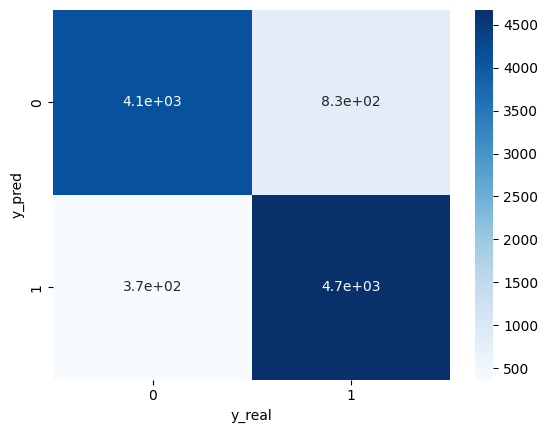

In [59]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

## Predicciones

In [60]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [61]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_{current_date}.csv", index=False)

## Mejora del modelo

### Intentamos con la lemmarizacion (2 Dense Layers)

In [12]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [13]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=20)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 512, 'learning_rate': 0.0001, 'threshold': 0.42}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 138ms/step - f1_score: 0.8043 - loss: 5.6687 - val_f1_score: 0.8815 - val_loss: 1.1491 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - f1_score: 0.9115 - loss: 0.8741 - val_f1_score: 0.8850 - val_loss: 0.6021 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - f1_score: 0.9221 - loss: 0.4845 - val_f1_score: 0.8730 - val_loss: 0.5093 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - f1_score: 0.9231 - loss: 0.3917 - val_f1_score: 0.8835 - val_loss: 0.4580 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - f1_score: 0.9204 - loss: 0.3661 - val_f1_score: 0.8768 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - f1_score: 0.9228 - loss: 0.3555 - val_f1_

In [14]:
if best_params['optimizer'] == 'rmsprop':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_61           │ (None, 20000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 512)            │    10,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241,025 (39.07 MB)

 Trainable params: 10,241,025 (39.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - f1_score: 0.8049 - loss: 5.7262 - val_f1_score: 0.8835 - val_loss: 1.1682 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - f1_score: 0.9153 - loss: 0.8911 - val_f1_score: 0.8797 - val_loss: 0.6197 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - f1_score: 0.9197 - loss: 0.4926 - val_f1_score: 0.8785 - val_loss: 0.5107 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - f1_score: 0.9211 - loss: 0.4035 - val_f1_score: 0.8832 - val_loss: 0.4597 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - f1_score: 0.9241 - loss: 0.3645 - val_f1_score: 0.8842 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - f1_score: 0.9246 - loss: 0.3521 - val_f1_score: 0.8798 - val_loss: 0.4414 - learning_rate: 1.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 13

In [15]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
F1-Score del modelo de red neuronal: 0.8885289634146342


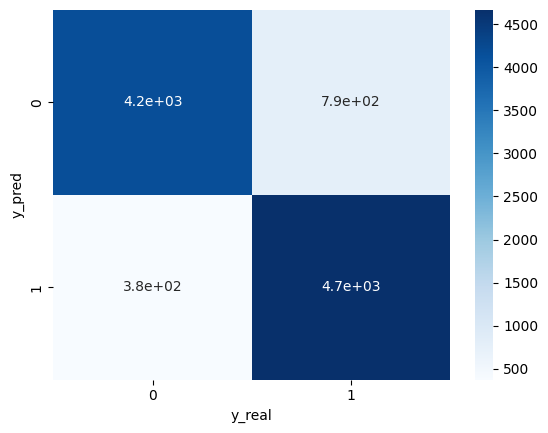

In [16]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [17]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,ID,sentimiento
0,60000,positivo
1,60001,positivo
2,60002,positivo
3,60003,positivo
4,60004,positivo
...,...,...
8594,68594,positivo
8595,68595,positivo
8596,68596,positivo
8597,68597,negativo


In [18]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_{current_date}.csv", index=False)

### Intentamos con la lemmarizacion y Dropout layers

In [21]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [22]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, max_tokens=10000, dropout_rate=0.5):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'max_tokens': [5000, 10000, 20000],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=20)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 16, 'learning_rate': 0.001, 'threshold': 0.4, 'max_tokens': 10000, 'dropout_rate': 0.6}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - f1_score: 0.7284 - loss: 0.7200 - val_f1_score: 0.8633 - val_loss: 0.4785 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - f1_score: 0.8362 - loss: 0.5269 - val_f1_score: 0.8737 - val_loss: 0.4799 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - f1_score: 0.8416 - loss: 0.5139 - val_f1_score: 0.8700 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - f1_score: 0.8459 - loss: 0.5103 - val_f1_score: 0.8688 - val_loss: 0.4813 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - f1_score: 0.8426 - loss: 0.5193 - val_f1_score: 0.8690 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - f1_score: 0.8429 - loss: 0.5119 -

In [23]:
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_122          │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - f1_score: 0.7366 - loss: 0.7422 - val_f1_score: 0.8668 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - f1_score: 0.8441 - loss: 0.5318 - val_f1_score: 0.8725 - val_loss: 0.4942 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - f1_score: 0.8525 - loss: 0.5186 - val_f1_score: 0.8706 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - f1_score: 0.8517 - loss: 0.5199 - val_f1_score: 0.8584 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - f1_score: 0.8546 - loss: 0.5200 - val_f1_score: 0.8764 - val_loss: 0.4993 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - f1_score: 0.8622 - loss: 0.4914 - val_f1_score: 0.8738 - val_loss: 0.4454 - learning_rate: 2.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - f1_score: 0.8731 - lo

In [24]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
F1-Score del modelo de red neuronal: 0.8879557167398359


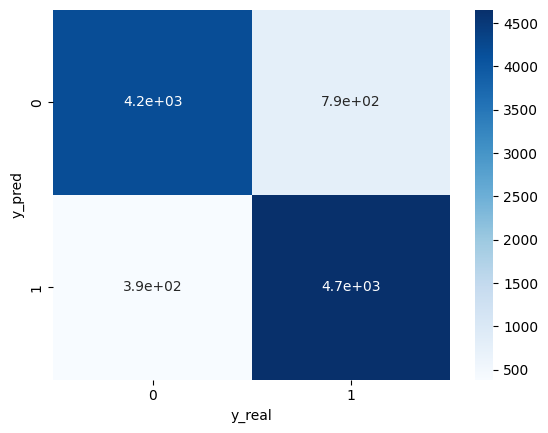

In [25]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [26]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [27]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_dropout_dense_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_dropout_dense_{current_date}.csv", index=False)

### Poner mas hiperparametros optimizados

In [4]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [6]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, epochs=10, batch_size=32, max_tokens=10000):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'batch_size': [32, 64, 128, 256],
    'epochs': [10, 20, 50, 100],
    'max_tokens': [5000, 10000, 20000]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'batch_size': [32, 64, 128, 256],
    'epochs': [10, 20, 50, 100],
    'max_tokens': [5000, 10000, 20000]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'batch_size': [32, 64, 128, 256],
    'epochs': [10, 20, 50, 100],
    'max_tokens': [5000, 10000, 20000]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=params['epochs'], 
                batch_size=params['batch_size'], 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>val_predictions.flatten().mean(),1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=30)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 512, 'learning_rate': 0.0001, 'threshold': 0.45, 'batch_size': 128, 'epochs': 10, 'max_tokens': 5000}
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - f1_score: 0.7388 - loss: 7.0472 - val_f1_score: 0.8753 - val_loss: 2.3133 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - f1_score: 0.8895 - loss: 1.8401 - val_f1_score: 0.8777 - val_loss: 1.0576 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - f1_score: 0.8943 - loss: 0.9010 - val_f1_score: 0.8761 - val_loss: 0.6875 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - f1_score: 0.8963 - loss: 0.6016 - val_f1_score: 0.8772 - val_loss: 0.5505 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - f1_score: 0.8983 - loss: 0.4812 - val_f1_score: 0.8718 - val_loss: 0.4842 - learning_rate: 1.0000e-04
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/s

In [8]:
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_90           │ (None, 20000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 32)             │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,065 (2.44 MB)

 Trainable params: 640,065 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - f1_score: 0.7578 - loss: 0.8811 - val_f1_score: 0.8893 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - f1_score: 0.9192 - loss: 0.4213 - val_f1_score: 0.8913 - val_loss: 0.4266 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - f1_score: 0.9317 - loss: 0.3427 - val_f1_score: 0.8870 - val_loss: 0.4035 - learning_rate: 1.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - f1_score: 0.9384 - loss: 0.3117 - val_f1_score: 0.8863 - val_loss: 0.3956 - learning_rate: 1.0000e-04
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - f1_score: 0.9403 - loss: 0.2946 - val_f1_score: 0.8814 - val_loss: 0.3970 - learning_rate: 1.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - f1_score: 0.9405 - loss: 0.2895 - val_f1_score: 0.8906 - val_loss: 0.3936 - learning_rate: 1.0000e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/ste

In [9]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>y_predic.flatten().mean(),1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
F1-Score del modelo de red neuronal: 0.8873740367516301


In [10]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>y_predic.flatten().mean(),1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,positivo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [11]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_hiperparametros_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_hiperparametros_{current_date}.csv", index=False)

# 5. Ensamble de 3 modelos (o mas)

In [3]:
class KerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = load_model(model_path)
    
    def fit(self, X, y):
        # Keras models are typically pre-trained, so we might not need this.
        return self
    
    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model.predict(X)
    
    def summary(self):
        return self.model.summary()

## Importaciones

In [14]:
# Tomando los ultimos y los mejores (que no es el ultimo) de cada modelo

ultimo_nb_model = joblib.load('Modelos/bn_model_2024-06-15.joblib')
mejor_nb_model = joblib.load('Modelos/bn_model_2024-05-31.joblib')

if hasattr(ultimo_nb_model, 'force_alpha') and ultimo_nb_model.force_alpha not in [True, False]:
    ultimo_nb_model.force_alpha = True
if hasattr(mejor_nb_model, 'force_alpha') and mejor_nb_model.force_alpha not in [True, False]:
    mejor_nb_model.force_alpha = True

ultimo_xgb_model = joblib.load('Modelos/xgb_model_2024-06-15.joblib')
mejor_xgb_model = joblib.load('Modelos/xgb_model_2024-05-28.joblib')

ultimo_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')
mejor_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

ultimo_keras_model = KerasClassifier('Modelos/red_neuronal_2024-06-15.h5')
mejor_keras_model = KerasClassifier('Modelos/red_neuronal_2024-06-15.h5')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NameError: name 'KerasClassifier' is not defined

In [33]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Voting

### Creacion del Ensamble

In [16]:
f1_scores = {
    'ultimo nb': 0.74588,
    'mejor nb': 0.74840,
    'ultimo xgb': 0.70304,
    'mejor xgb': 0.71215,
    'ultimo rf': 0.68773,
    'mejor rf': 0.68773,
    #'ultimo keras': 0.75770,
    #'mejor keras': 0.76584
}

total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

# Crear el ensamble
ensemble = VotingClassifier(estimators=[
    ('ultimo nb', ultimo_nb_model),
    ('mejor nb', mejor_nb_model),
    ('ultimo xgb', ultimo_xgb_model),
    ('mejor xgb', mejor_xgb_model),
    ('ultimo rf', ultimo_rf_model),
    ('mejor rf', mejor_rf_model),
    #('ultimo keras', ultimo_keras_model),
    #('mejor keras', mejor_keras_model)
], voting='soft', weights=initial_weights)  # 'soft' para probabilidades, 'hard' para mayorías

vect = TfidfVectorizer(stop_words=stop_words_es)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

# Ajustar el modelo de ensamble
ensemble.fit(X_train_vect, y_train)

KeyboardInterrupt: 

In [35]:
# Predicciones del ensamble
y_pred = ensemble.predict(X_test_vect)

# Evaluación
f1 = f1_score(y_test, y_pred)

print(f'F1-Score: {f1}')

F1-Score: 0.8866686257224018


### Conjunto Test

In [36]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = ensemble.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Exportaciones

In [37]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_voting_{current_date}.csv", index=False)

joblib.dump(ensemble, f'Modelos/Ensamble_voting_{current_date}.joblib')

['Modelos/Ensamble_voting_2024-06-15.joblib']

### Intentamos con redes neuronales unicamente

In [113]:
class KerasVotingClassifier:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights is not None else [1] * len(models)

    def fit(self, X_train, y_train, X_train_list):
        for model in self.models:
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_train_list)

            model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[F1Score])
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    def predict(self, X, X_list=None):
        prediction_list = []
        for model in self.models :
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_list)
            prediction_list.append(model.predict(X))
        
        predictions = np.array(prediction_list)

        avg_predictions = (np.average(predictions, axis=0, weights=self.weights) > 0.4).astype(int)

        weighted_sum = np.zeros(predictions[0].shape)
        for i in range(len(self.weights)):
            weighted_sum += self.weights[i] * (predictions[i] > 0.4).astype(int)
        majority_predictions = (weighted_sum > (sum(self.weights) / 2)).astype(int)
        
        return avg_predictions, majority_predictions

In [114]:
models = [
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_2024-06-11.h5'),
    load_model('Modelos/red_neuronal_2024-06-14.h5'),
    load_model('Modelos/red_neuronal_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_2024-06-17.h5')
]

X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

In [115]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [116]:
f1_scores = {
    'keras1': 0.76662,
    'keras2': 0.76623,
    'keras3': 0.76584,
    'keras4': 0.75789,
    'keras5': 0.75770,
    'keras6': 0.75596,
}

total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

voting_classifier = KerasVotingClassifier(models=models, weights=initial_weights)
voting_classifier.fit(X_train_array, y_train, X_train_list)

# Predicciones del ensamble
y_pred_avg, y_pred_maj = voting_classifier.predict(X_test_array, X_train_list)

# Evaluación
f1_avg = f1_score(y_test, y_pred_avg)
f1_maj = f1_score(y_test, y_pred_maj)
if f1_avg > f1_maj:
    mejor = "avg"
else :
    mejor = "maj"

print(f'F1-Score - Promedio: {f1_avg}')
print(f'F1-Score - Mayoria: {f1_maj}')

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - f1_score: 0.6662 - loss: 0.5323
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - f1_score: 0.6633 - loss: 0.4764
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - f1_score: 0.6669 - loss: 0.4715
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - f1_score: 0.6677 - loss: 0.4627
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - f1_score: 0.6697 - loss: 0.4455
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - f1_score: 0.6690 - loss: 0.4330
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - f1_score: 0.6642 - loss: 0.4231
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - f1_score: 0.6656 - loss: 0.4182
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - f1_score: 0.6629 - loss: 0.4191
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - f1_score: 0.6655 - loss: 0.4099
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 111ms/step - f1_score: 0.6706 - loss: 0.9979
Epoch 2/10
1250/1250

In [117]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_list = X_conjunto_test.tolist()

pred_test_avg, pred_test_maj = voting_classifier.predict(X_conjunto_test, X_conjunto_test_list)

if mejor == "avg":
    pred_test = pred_test_avg
else :
    pred_test = pred_test_maj

pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [118]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_voting_redes_neuronales_{current_date}.csv", index=False)

## Stacking

### Creacion del ensamble

In [38]:
vect = TfidfVectorizer(stop_words=stop_words_es, min_df=2, ngram_range=(1,3))

X_train_vect = vect.fit_transform(X_train).astype('float32')
X_test_vect = vect.transform(X_test).astype('float32')

In [39]:
f1_scores = {
    'ultimo nb': 0.74588,
    'mejor nb': 0.74840,
    'ultimo xgb': 0.70304,
    'mejor xgb': 0.71215,
    'ultimo rf': 0.68773,
    'mejor rf': 0.68773,
    #'ultimo keras': 0.75770,
    #'mejor keras': 0.76584
}

total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

# Crear el ensamble
base_models = [
    ('ultimo nb', ultimo_nb_model),
    ('mejor nb', mejor_nb_model),
    ('ultimo xgb', ultimo_xgb_model),
    ('mejor xgb', mejor_xgb_model),
    ('ultimo rf', ultimo_rf_model),
    ('mejor rf', mejor_rf_model),
    #('ultimo keras', ultimo_keras_model),
    #('mejor keras', mejor_keras_model)
]

base_predictions_train = np.zeros((X_train_vect.shape[0], len(base_models)))
base_predictions_test = np.zeros((X_test_vect.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    model.fit(X_train_vect, y_train)
    base_predictions_train[:, i] = cross_val_predict(model, X_train_vect, y_train, cv=5, method='predict_proba')[:, 1]
    base_predictions_test[:, i] = model.predict_proba(X_test_vect)[:, 1]

meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(base_predictions_train, y_train)

final_predictions = meta_learner.predict(base_predictions_test)

# Evaluación
f1 = f1_score(y_test, final_predictions)

print(f'F1-Score: {f1}')

F1-Score: 0.8994176290593229


### Conjunto test

In [40]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

base_predictions_conjunto_test = np.zeros((X_conjunto_test.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    base_predictions_conjunto_test[:, i] = model.predict_proba(X_conjunto_test)[:, 1]

pred_test = meta_learner.predict(base_predictions_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Exportaciones

In [41]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_stacking_{current_date}.csv", index=False)

joblib.dump(meta_learner, f'Modelos/Ensamble_stacking_{current_date}.joblib')

['Modelos/Ensamble_stacking_2024-06-16.joblib']

### Intentamos con redes neuronales

In [119]:
class KerasStackingClassifier:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights is not None else [1] * len(models)

    def fit(self, X_train, y_train, X_train_list):
        self.meta_learner = LogisticRegression(random_state=42)
        self.base_predictions_train = np.zeros((X_train.shape[0], len(self.models)))
        
        for i, model in enumerate(self.models):
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_train_list)
            self.base_predictions_train[:, i] = model.predict(X_train).flatten()

        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'liblinear'],
            'penalty': ['l1', 'l2', 'elasticnet']
        }
        grid_search = GridSearchCV(self.meta_learner, param_grid, cv=5, scoring='f1')
        grid_search.fit(self.base_predictions_train, y_train)
        
        self.meta_learner = grid_search.best_estimator_
        self.meta_learner.fit(self.base_predictions_train, y_train)

    def predict(self, X_test, X_test_list):
        base_predictions_test = np.zeros((X_test.shape[0], len(self.models)))
        
        for i, model in enumerate(self.models):
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_test_list)
            base_predictions_test[:, i] = model.predict(X_test).flatten()

        final_predictions = self.meta_learner.predict(base_predictions_test)
        return final_predictions

In [120]:
models = [
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_2024-06-11.h5'),
    load_model('Modelos/red_neuronal_2024-06-14.h5'),
    load_model('Modelos/red_neuronal_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_2024-06-17.h5')
]

X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1, 1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1, 1)

In [121]:
stacking_classifier = KerasStackingClassifier(models=models)
stacking_classifier.fit(X_train_array, y_train, X_train_list)

final_predictions = stacking_classifier.predict(X_test_array, X_test_list)

f1 = f1_score(y_test, final_predictions)
print(f'F1-Score: {f1}')

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step


c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packag

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
F1-Score: 0.8724752475247525


In [122]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_list = X_conjunto_test.tolist()
X_conjunto_test_array = np.array(X_conjunto_test_list, dtype=object).reshape(-1, 1)

pred_test = stacking_classifier.predict(X_conjunto_test_array, X_conjunto_test_list)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,ID,sentimiento
0,60000,positivo
1,60001,negativo
2,60002,positivo
3,60003,positivo
4,60004,positivo
...,...,...
8594,68594,positivo
8595,68595,positivo
8596,68596,positivo
8597,68597,negativo


In [123]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')
final_pred_df.to_csv(f"Predicciones/Ensamble_stacking_redes_neuronales_{current_date}.csv", index=False)
joblib.dump(stacking_classifier.meta_learner, f'Modelos/Ensamble_stacking_redes_neuronales_{current_date}.joblib')

['Modelos/Ensamble_stacking_redes_neuronales_2024-06-19.joblib']